CNN
  - 데이터취득 - 전처리(데이터 증강, 정규화)
  - 이미지분류(CNN)
  - 전이학습 모델 VGG 분류

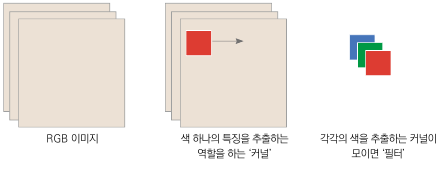

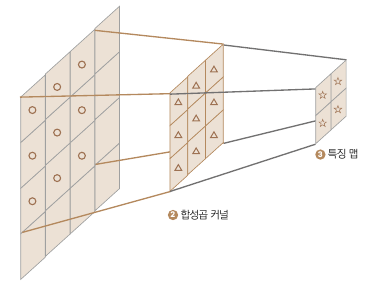

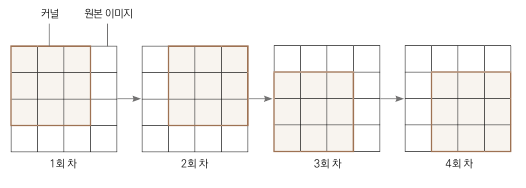

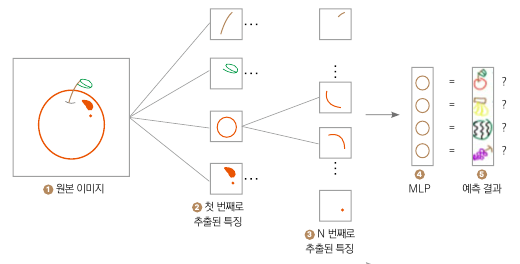

전이학습
  - VGG : 3x3
  - inception : 3 x 3 커널을 여러번 중첩해서
  - ResNet : 층이깊어지면 기울기 소실문제를 어느정도 해결한 모델


In [ ]:
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

In [ ]:
train_dataset = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)
test_dataset = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12895994.20it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


데이터 증대
  - 크롭핑, 좌우대칭

  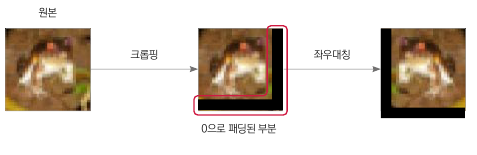

Files already downloaded and verified
Files already downloaded and verified


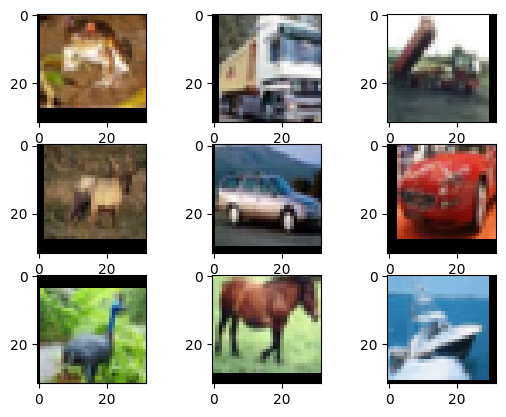

In [ ]:
import torchvision.transforms as T
from torchvision.transforms import Compose, RandomHorizontalFlip,RandomCrop

transforms =  Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4), # 랜덤으로 일부 이미지를 제거한후 패딩
    RandomHorizontalFlip(p=0.5)
])
train_dataset = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)
test_dataset = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(transforms(train_dataset.data[i]))

이미지 정규화

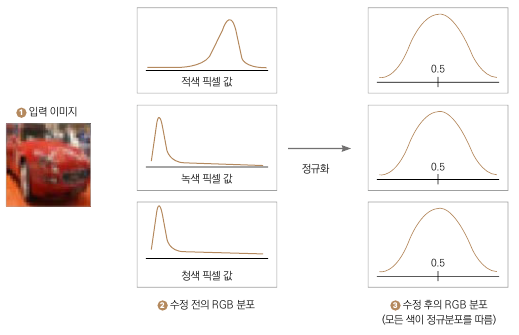

정규화된 이미지 확인

Files already downloaded and verified
Files already downloaded and verified


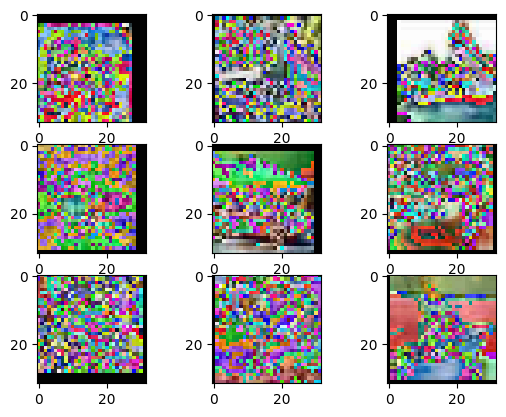

In [ ]:
import torchvision.transforms as T
from torchvision.transforms import Compose, RandomHorizontalFlip,RandomCrop,Normalize

transforms =  Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4), # 랜덤으로 일부 이미지를 제거한후 패딩
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=(0.4,0.4,0.4),std=(0.2,0.2,0.2)),
    T.ToPILImage()
])
train_dataset = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)
test_dataset = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(transforms(train_dataset.data[i]))

정규화 과정에서 사용했던 RGB 채널의 mean std를 구해보자

In [ ]:
train_dataset = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified


In [ ]:
images = [data for data,label in train_dataset]

In [ ]:
import torch
import numpy as np
# image를 하나로 합침
ims = torch.stack(images,dim = 0).numpy()

In [ ]:
ims.shape

(50000, 3, 32, 32)

In [ ]:
mean_r = ims[:, 0, :, :].mean()
mean_g = ims[:, 1, :, :].mean()
mean_b = ims[:, 2, :, :].mean()

std_r = ims[:, 0, :, :].std()
std_g = ims[:, 1, :, :].std()
std_b = ims[:, 2, :, :].std()

mean_r,mean_g,mean_b,std_r,std_g,std_b

(0.49139968, 0.48215827, 0.44653124, 0.24703233, 0.24348505, 0.26158768)

신경망 만들기
  - 간단한 신경망은 nn.Sequencial
  - 복잡한 신경망은 nn.Module

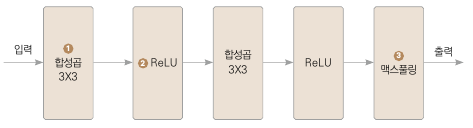

In [ ]:
# 맥스폴링은 이미지 크기를 절반으로 줄이는 연산-> 합성곱을 통해서 얻은 특징의 위치정보를 의도적으로 없앰
# 오버피팅을 방지, 커널이동하면서 커널의 최대값만 남기기때문에 중요한 특성정보는 보존

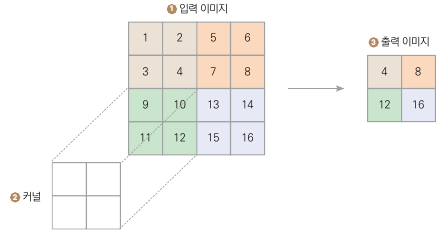

구현

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, hidden_dim ):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channel,hidden_dim,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(hidden_dim,out_channel,kernel_size=3,padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
  def forward(self,x): # 순전파
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    return x

conv - kernel 패딩이 없는경우

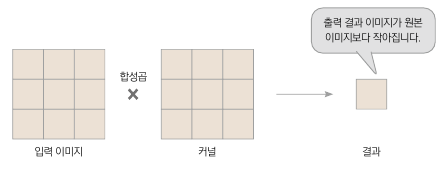

합성곱 전후로 이미지크기를 동일하게 맞추려면... 패딩

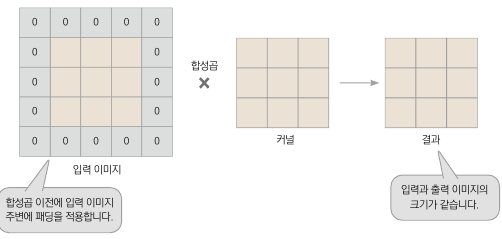

컨볼류션을 통과한 데이터는 평탄화 작업을 수행한다.

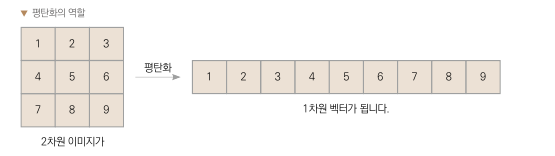

CNN모델

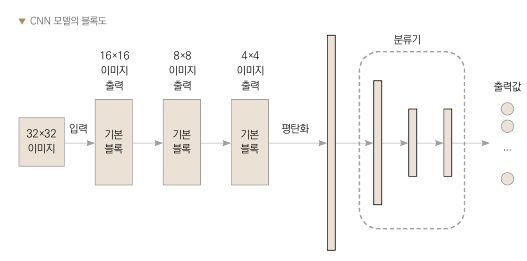

In [ ]:
class DumyCNN(nn.Module):
  def __init__(self,num_class):
    super(DumyCNN,self).__init__()
    # 합성곱 기존 블럭
    self.block1 = BasicBlock(3,32,16)
    self.block2 = BasicBlock(32,128,64)
    self.block3 = BasicBlock(128,256,128)
  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x,start_dim=1)  # 2차원 특징 맵을 1차원
    print(x.shape)
    return x


from torch.utils.data import dataloader
train_dataset = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_dataset = CIFAR10(root='./', train=False, download=True, transform=transforms)

# 데이터 로드
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

tempmodel = DumyCNN(10)
for data,label in train_loader:
  tempmodel(data)
  break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([32, 4096])


VGG 모델(basicBlock 사용)

In [ ]:
class CNN(nn.Module):
  def __init__(self,num_class):
    super(CNN,self).__init__()
    # 합성곱 기존 블럭
    self.block1 = BasicBlock(3,32,16)
    self.block2 = BasicBlock(32,128,64)
    self.block3 = BasicBlock(128,128,128)

    # 분류기 FC
    self.fc1 = nn.Linear(in_features=2048,out_features=2048)
    self.fc2 = nn.Linear(in_features=2048,out_features=256)
    self.fc3 = nn.Linear(in_features=256,out_features=num_class)

    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x,start_dim=1)  # 2차원 특징 맵을 1차원

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)

    return x

데이터 증강

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.4,0.4,0.4),std=(0.2,0.2,0.2))
])

데이터 로드 및 모델정의

In [ ]:
from torch.utils.data import dataloader
train_dataset = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_dataset = CIFAR10(root='./', train=False, download=True, transform=transforms)

# 데이터 로드
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

# 학습프로세서 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 정의
model = CNN(10)

# 모델을 device로 보냄
model.to(device)

#학습률
lr = 1e-3
# 최적화
optim = Adam(model.parameters(),lr=lr)
#학습
for epoch in range(100):
  for data,label in train_loader:
    # 기울기 초기화
    optim.zero_grad()
    preds = model(data.to(device))
    loss = nn.CrossEntropyLoss()(preds,label.to(device))
    loss.backward()
    optim.step()
  if epoch==0 or epoch%10==0:
    print(f"epoch:{epoch} loss:{loss.item()}")

torch.save(model.state_dict(),"CIFAR.pth")

Files already downloaded and verified
Files already downloaded and verified
epoch:0 loss:1.3197017908096313
epoch:10 loss:0.1184011921286583
epoch:20 loss:0.6034436225891113
epoch:30 loss:0.5927003622055054
epoch:40 loss:0.7787128686904907
epoch:50 loss:0.2839769423007965
epoch:60 loss:0.4597577750682831
epoch:70 loss:0.18848328292369843
epoch:80 loss:0.13676251471042633
epoch:90 loss:0.08014994114637375


모델성능 확인

In [ ]:
model.load_state_dict(torch.load('CIFAR.pth',map_location=device))

<All keys matched successfully>

In [ ]:
num_corr = 0
with torch.no_grad():
  for data,label in test_loader:
    output = model(data.to(device))
    preds = output.max(1)[1]
    corr = preds.eq(label.to(device)).sum().item()
    num_corr += corr

print(f"accuracy : {num_corr/len(test_dataset)}")

accuracy : 0.8281


동일데이터를 VGG 모델에서 학습

In [1]:
import torch
import torch.nn as nn

In [2]:
from torchvision.models.vgg import vgg16
device =  "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
model = vgg16(pretrained = True) # 모델불러오기 conv층만 있음
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
fc = nn.Sequential(
  nn.Linear(in_features=25088,out_features=4096)   ,
  nn.ReLU(),
  nn.Dropout(0.5),
  nn.Linear(in_features=4096,out_features=4096),
  nn.ReLU(),
  nn.Dropout(0.5),
  nn.Linear(in_features=4096,out_features=10),
)
model.classifier = fc
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

데이터 불러와서 학습하기

In [9]:
import tqdm
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose,ToTensor,Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop,Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

In [10]:
transforms = Compose([
    Resize(224),
    RandomCrop( (224,224),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (0.5,0.5,0.5), std = (0.2,0.2,0.2))
])

In [11]:
training_data =  CIFAR10(root='./',train=True,download=True,transform=transforms)
test_data = CIFAR10(root='./',train=False,download=True,transform=transforms)

train_loader = DataLoader(training_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)


100%|██████████| 170498071/170498071 [00:13<00:00, 12777356.34it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [18]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

학습 루프정의

In [20]:
lr = 1e-4
optim = Adam(model.parameters(),lr=lr)
for epoch in range(2):
  iterloader = tqdm.tqdm(train_loader)
  for data,label in iterloader:
    optim.zero_grad() # 가중치 0 다음계산에 남아있는 가중치를 제거
    # 전방계산 forward
    preds = model(data.to(device))
    loss = nn.CrossEntropyLoss()(preds,label.to(device))
    loss.backward() # 가중치 업데이트
    optim.step() # 가중치 최적화
    # tqdm 출력 업데이트

    iterloader.set_description(f"epoch{epoch} loss{loss.item()}")
torch.save(model.state_dict, "CIFAR_vgg16.pth")

epoch1 loss0.1947682797908783: 100%|██████████| 1563/1563 [13:44<00:00,  1.90it/s]


평가

In [24]:
# model.load_state_dict(torch.load('CIFAR_vgg16.pth',map_location=device))
num_corr = 0
with torch.no_grad():
  for data, label in test_loader:
    output = model(data.to(device))
    preds = output.data.max(1)[1]  # output.data.max(1) --> np.argmax(output, axis=1)  -- [0] 실제데이터 [1] 인덱스
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr

print(f"Accuracy:{num_corr / len(test_data)}")


Accuracy:0.8935
